In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

2023-12-12 20:11:28.189588: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Parâmetros

In [2]:
TEST_SIZE = 0.3
EPOCHS = 10
BATCH_SIZE = 250
ACTV_FUNC = 'relu'

### Carregando os dados

In [3]:
all_data = pd.read_csv("train.csv")

Y_all = all_data["label"]
Y_all = to_categorical(Y_all, num_classes=10)

X_all = all_data.drop(labels=["label"], axis=1)
X_all = X_all / 255.0
X_all = X_all.values.reshape(-1, 28, 28, 1)

### Separando os dados em treino e teste

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X_all,
    Y_all,
    test_size=TEST_SIZE,
    random_state=2
)

print(f"X_train: {X_train.shape}\nY_train: {Y_train.shape}")
print(f"X_test: {X_test.shape}\nY_test: {Y_test.shape}")



X_train: (29400, 28, 28, 1)
Y_train: (29400, 10)
X_test: (12600, 28, 28, 1)
Y_test: (12600, 10)


### Amostra dos dados

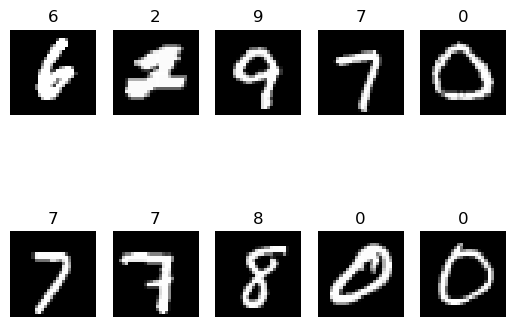

In [5]:
fig, ax = plt.subplots(2, 5)
for i in range(2):
    for j in range(5):
        ax[i, j].imshow(X_train[i * 5 + j][:, :, 0], cmap='gray')
        ax[i, j].axis('off')
        ax[i, j].set_title(Y_train[i * 5 + j].argmax())
plt.show()

### Criando o modelo

In [6]:
model = Sequential([
    Conv2D(filters=8, kernel_size=(5, 5), activation=ACTV_FUNC, input_shape=(28, 28, 1)),
    MaxPool2D(pool_size=(2, 2)),
    Conv2D(filters=16, kernel_size=(3, 3), activation=ACTV_FUNC),
    MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    Flatten(),
    Dense(256, activation=ACTV_FUNC),
    Dense(10, activation="softmax")
])

optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

2023-12-12 20:11:34.667162: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


### Ampliando os dados de treino

In [7]:
datagen = ImageDataGenerator(
    featurewise_center=False,               # Define a média de entrada como 0 sobre o conjunto de dados
    samplewise_center=False,                # Define a média de cada amostra como 0
    featurewise_std_normalization=False,    # Divide as entradas pelo desvio padrão do conjunto de dados
    samplewise_std_normalization=False,     # Divide cada entrada pelo seu desvio padrão
    zca_whitening=False,                    # Redução de dimensão ZCA
    rotation_range=5,                       # Rotaciona aleatoriamente as imagens no intervalo de 5 graus
    zoom_range=0.1,                         # Ampliação aleatória da imagem em 10%
    width_shift_range=0.1,                  # Desloca aleatoriamente as imagens horizontalmente em 10%
    height_shift_range=0.1,                 # Desloca aleatoriamente as imagens verticalmente em 10%
    horizontal_flip=False,                  # Inverte aleatoriamente as imagens horizontalmente
    vertical_flip=False                     # Inverte aleatoriamente as imagens verticalmente
)  

datagen.fit(X_train)

### Treinando o modelo

In [8]:
history = model.fit(
    datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=(X_test, Y_test),
    steps_per_epoch=X_train.shape[0] // BATCH_SIZE
)

Epoch 1/10


2023-12-12 20:11:35.291509: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


117/117 [==============================] - 39s 330ms/step - loss: 0.9062 - accuracy: 0.7298 - val_loss: 0.1758 - val_accuracy: 0.9501
Epoch 2/10
117/117 [==============================] - 42s 357ms/step - loss: 0.2866 - accuracy: 0.9138 - val_loss: 0.1291 - val_accuracy: 0.9615
Epoch 3/10
117/117 [==============================] - 43s 373ms/step - loss: 0.1958 - accuracy: 0.9417 - val_loss: 0.1263 - val_accuracy: 0.9626
Epoch 4/10
117/117 [==============================] - 41s 348ms/step - loss: 0.1619 - accuracy: 0.9514 - val_loss: 0.0908 - val_accuracy: 0.9730
Epoch 5/10
117/117 [==============================] - 49s 421ms/step - loss: 0.1387 - accuracy: 0.9588 - val_loss: 0.0869 - val_accuracy: 0.9725
Epoch 6/10
117/117 [==============================] - 38s 328ms/step - loss: 0.1208 - accuracy: 0.9650 - val_loss: 0.0738 - val_accuracy: 0.9778
Epoch 7/10
117/117 [==============================] - 39s 332ms/step - loss: 0.1094 - accuracy: 0.9678 - val_loss: 0.0782 - val_accuracy: 0.9

### Gráfico de perda de precisão para treinamento e acurácia

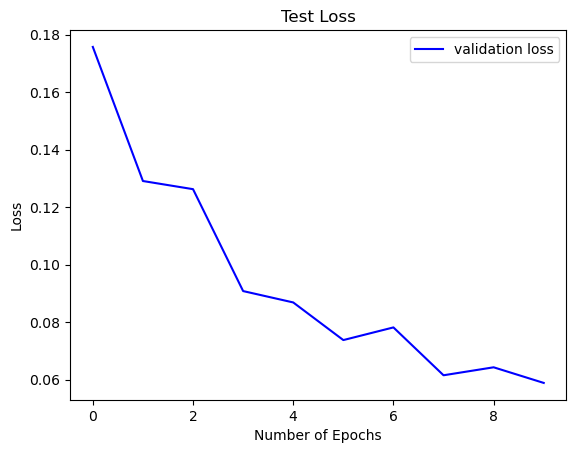

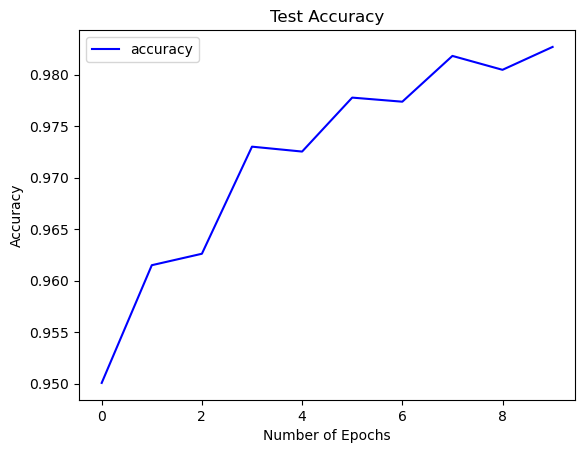

In [9]:
plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.close()


plt.plot(history.history['val_accuracy'], color='b', label="accuracy")
plt.title("Test Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
plt.close()

### Previsão utilizando os dados de teste

In [10]:
Y_pred = model.predict(X_test)

394/394 [==============================] - 13s 32ms/step


### Matriz de confusão para os dados de teste

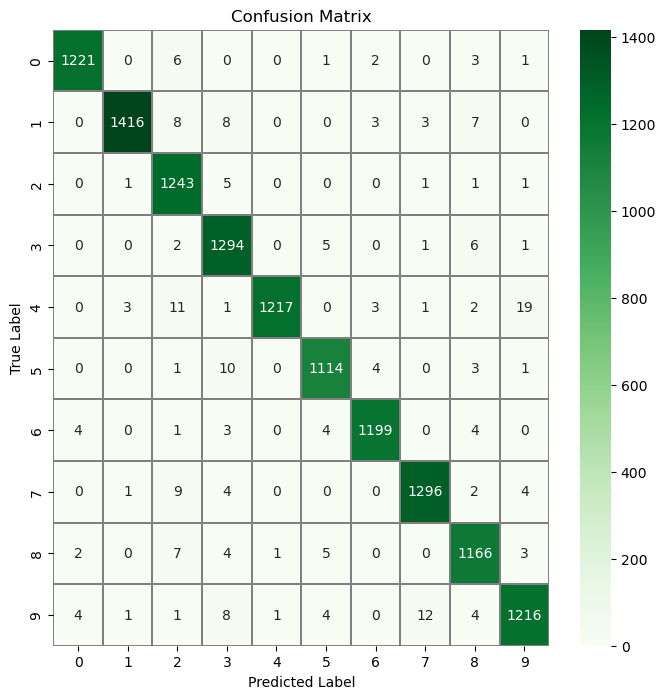

In [11]:
# Converte classes de predições em um vetor
Y_pred_classes = np.argmax(Y_pred, axis=1)
# Converte observações de validação em um vetor
Y_true = np.argmax(Y_test, axis=1)
# computa a matriz de confusao
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# Mostra a matriz de confusao
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="Greens", linecolor="gray", fmt='.0f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
plt.close()
